# Real vs Fake News Headlines Feature Analysis

## Objective
Analyze the key differences between real and fake news headlines to understand:
1. Why traditional ML models perform well on headline classification
2. What specific features distinguish real from fake news headlines
3. How to generate better synthetic headlines based on these insights

## Dataset
- **GossipCop Real headlines**: From gossipcop_real.csv
- **GossipCop Fake headlines**: From gossipcop_fake.csv
- **PolitiFact Real headlines**: From politifact_real.csv
- **PolitiFact Fake headlines**: From politifact_fake.csv
- **Source**: data/headlines/ folder

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import re
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Text processing
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import nltk
from textstat import flesch_reading_ease, flesch_kincaid_grade

# Try to import TextBlob for sentiment analysis
try:
    from textblob import TextBlob
    TEXTBLOB_AVAILABLE = True
except ImportError:
    TEXTBLOB_AVAILABLE = False
    print("TextBlob not available, sentiment analysis will be skipped")

plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

## 1. Data Loading and Basic Overview

In [14]:
# Load all headline datasets
gossipcop_real = pd.read_csv('../data/headlines/gossipcop_real.csv')
gossipcop_fake = pd.read_csv('../data/headlines/gossipcop_fake.csv')
politifact_real = pd.read_csv('../data/headlines/politifact_real.csv')
politifact_fake = pd.read_csv('../data/headlines/politifact_fake.csv')

print("Dataset Overview:")
print(f"GossipCop Real headlines: {len(gossipcop_real)}")
print(f"GossipCop Fake headlines: {len(gossipcop_fake)}")
print(f"PolitiFact Real headlines: {len(politifact_real)}")
print(f"PolitiFact Fake headlines: {len(politifact_fake)}")

# Extract headlines and create labels
real_headlines = []
fake_headlines = []

# Add GossipCop headlines
real_headlines.extend(gossipcop_real['title'].dropna().tolist())
fake_headlines.extend(gossipcop_fake['title'].dropna().tolist())

# Add PolitiFact headlines
real_headlines.extend(politifact_real['title'].dropna().tolist())
fake_headlines.extend(politifact_fake['title'].dropna().tolist())

print(f"\nCombined Dataset:")
print(f"Total Real headlines: {len(real_headlines)}")
print(f"Total Fake headlines: {len(fake_headlines)}")
print(f"Total headlines: {len(real_headlines) + len(fake_headlines)}")

# Display some examples
print("\nExample Real Headlines:")
for i, headline in enumerate(real_headlines[:5]):
    print(f"{i+1}. {headline}")

print("\nExample Fake Headlines:")
for i, headline in enumerate(fake_headlines[:5]):
    print(f"{i+1}. {headline}")

Dataset Overview:
GossipCop Real headlines: 16817
GossipCop Fake headlines: 5323
PolitiFact Real headlines: 624
PolitiFact Fake headlines: 432

Combined Dataset:
Total Real headlines: 17441
Total Fake headlines: 5755
Total headlines: 23196

Example Real Headlines:
1. Teen Mom Star Jenelle Evans' Wedding Dress Is Available Here for $2999
2. Kylie Jenner refusing to discuss Tyga on Life of Kylie
3. Quinn Perkins
4. I Tried Kim Kardashian's Butt Workout & Am Forever Changed
5. Celine Dion donates concert proceeds to Vegas shooting victims

Example Fake Headlines:
1. Did Miley Cyrus and Liam Hemsworth secretly get married?
2. Paris Jackson & Cara Delevingne Enjoy Night Out In Matching Outfits: They Have ‘Amazing Chemistry’
3. Celebrities Join Tax March in Protest of Donald Trump
4. Cindy Crawford's daughter Kaia Gerber wears a wig after dining with Harry Styles
5. Full List of 2018 Oscar Nominations – Variety


## 2. Comprehensive Feature Extraction for Headlines

We'll extract multiple types of features to understand the differences between real and fake news headlines:

In [4]:
class HeadlineFeatureExtractor:
    """Extract comprehensive features from news headlines for analysis"""
    
    def __init__(self):
        # Predefined word lists for news analysis
        self.clickbait_words = ['shocking', 'unbelievable', 'incredible', 'amazing', 'stunning', 'outrageous', 
                               'scandalous', 'exclusive', 'secret', 'exposed', 'revealed', 'bombshell', 
                               'you wont believe', 'this will', 'what happens next']
        
        self.sensational_words = ['breaking', 'urgent', 'alert', 'crisis', 'disaster', 'tragedy', 'scandal', 
                                 'controversy', 'explosive', 'dramatic', 'shocking', 'devastating']
        
        self.emotional_words = ['love', 'hate', 'fear', 'anger', 'joy', 'sad', 'happy', 'excited', 
                               'worried', 'concerned', 'thrilled', 'disappointed', 'frustrated']
        
        self.certainty_words = ['definitely', 'absolutely', 'certainly', 'surely', 'obviously', 'clearly', 
                               'undoubtedly', 'without doubt', 'confirmed', 'proven', 'fact', 'truth']
        
        self.speculation_words = ['allegedly', 'reportedly', 'supposedly', 'claims', 'suggests', 'may', 
                                 'might', 'could', 'possibly', 'potentially', 'appears', 'seems']
        
        self.political_words = ['president', 'government', 'congress', 'senate', 'politician', 'election', 
                               'vote', 'campaign', 'policy', 'law', 'bill', 'democrat', 'republican']
        
        self.celebrity_words = ['celebrity', 'star', 'actor', 'actress', 'singer', 'musician', 'model', 
                               'hollywood', 'famous', 'red carpet', 'award', 'grammy', 'oscar']
    
    def extract_length_features(self, texts):
        """Extract length-based features"""
        features = []
        
        for text in texts:
            text_str = str(text)
            words = text_str.split()
            sentences = [s for s in text_str.split('.') if s.strip()]
            
            features.append({
                'char_count': len(text_str),
                'word_count': len(words),
                'avg_word_length': np.mean([len(word) for word in words]) if words else 0,
                'sentence_count': len(sentences),
                'avg_sentence_length': len(words) / max(1, len(sentences)),
                'title_case_ratio': sum(1 for word in words if word.istitle()) / max(1, len(words))
            })
            
        return pd.DataFrame(features)
    
    def extract_stylistic_features(self, texts):
        """Extract stylistic and structural features"""
        features = []
        
        for text in texts:
            text_str = str(text)
            
            # Count various punctuation and symbols
            colon_count = text_str.count(':')
            dash_count = text_str.count('–') + text_str.count('-')
            quote_count = text_str.count('"') + text_str.count("'")
            
            features.append({
                'exclamation_count': text_str.count('!'),
                'question_count': text_str.count('?'),
                'colon_count': colon_count,
                'dash_count': dash_count,
                'quote_count': quote_count,
                'parentheses_count': text_str.count('(') + text_str.count(')'),
                'caps_word_count': len([word for word in text_str.split() if word.isupper() and len(word) > 1]),
                'upper_ratio': sum(1 for c in text_str if c.isupper()) / max(1, len(text_str)),
                'punctuation_density': sum(1 for c in text_str if c in '.,!?;:') / max(1, len(text_str)),
                'digit_count': sum(1 for c in text_str if c.isdigit()),
                'digit_ratio': sum(1 for c in text_str if c.isdigit()) / max(1, len(text_str)),
                'has_numbers': int(any(c.isdigit() for c in text_str))
            })
            
        return pd.DataFrame(features)
    
    def extract_semantic_features(self, texts):
        """Extract semantic and content-based features"""
        features = []
        
        for text in texts:
            text_str = str(text).lower()
            words = text_str.split()
            
            # Count different types of words
            clickbait_count = sum(1 for phrase in self.clickbait_words if phrase in text_str)
            sensational_count = sum(1 for word in words if word in self.sensational_words)
            emotional_count = sum(1 for word in words if word in self.emotional_words)
            certainty_count = sum(1 for word in words if word in self.certainty_words)
            speculation_count = sum(1 for word in words if word in self.speculation_words)
            political_count = sum(1 for word in words if word in self.political_words)
            celebrity_count = sum(1 for word in words if word in self.celebrity_words)
            
            # Sentiment analysis if available
            polarity = 0
            subjectivity = 0
            if TEXTBLOB_AVAILABLE:
                try:
                    blob = TextBlob(text)
                    polarity = blob.sentiment.polarity
                    subjectivity = blob.sentiment.subjectivity
                except:
                    pass
            
            features.append({
                'clickbait_word_count': clickbait_count,
                'sensational_word_count': sensational_count,
                'emotional_word_count': emotional_count,
                'certainty_word_count': certainty_count,
                'speculation_word_count': speculation_count,
                'political_word_count': political_count,
                'celebrity_word_count': celebrity_count,
                'sentiment_polarity': polarity,
                'sentiment_subjectivity': subjectivity,
                'speculation_certainty_ratio': speculation_count / max(1, certainty_count),
                'emotional_intensity': (emotional_count + sensational_count) / max(1, len(words))
            })
            
        return pd.DataFrame(features)
    
    def extract_linguistic_features(self, texts):
        """Extract linguistic complexity features"""
        features = []
        
        for text in texts:
            text_str = str(text)
            
            # Readability scores
            try:
                flesch_score = flesch_reading_ease(text_str)
                fk_grade = flesch_kincaid_grade(text_str)
            except:
                flesch_score = 0
                fk_grade = 0
            
            # Lexical diversity
            words = text_str.lower().split()
            unique_words = len(set(words))
            lexical_diversity = unique_words / max(1, len(words))
            
            # Function words (pronouns, articles, prepositions)
            function_words = ['the', 'a', 'an', 'in', 'on', 'at', 'to', 'for', 'with', 'by', 'of', 'is', 'are', 'was', 'were']
            function_word_count = sum(1 for word in words if word in function_words)
            function_word_ratio = function_word_count / max(1, len(words))
            
            features.append({
                'flesch_reading_ease': flesch_score,
                'flesch_kincaid_grade': fk_grade,
                'lexical_diversity': lexical_diversity,
                'function_word_ratio': function_word_ratio,
                'unique_word_count': unique_words,
                'repetition_ratio': 1 - lexical_diversity
            })
            
        return pd.DataFrame(features)
    
    def extract_headline_specific_features(self, texts):
        """Extract features specific to news headlines"""
        features = []
        
        for text in texts:
            text_str = str(text)
            
            # Common headline patterns
            has_says = int('says' in text_str.lower())
            has_reports = int(any(word in text_str.lower() for word in ['reports', 'report']))
            has_claims = int('claims' in text_str.lower())
            has_breaking = int('breaking' in text_str.lower())
            has_watch = int('watch' in text_str.lower())
            has_video = int('video' in text_str.lower())
            
            # Quote patterns
            has_quotes = int('"' in text_str or "'" in text_str)
            
            # Time references
            time_words = ['today', 'yesterday', 'now', 'latest', 'new', 'recent', 'current']
            has_time_ref = int(any(word in text_str.lower() for word in time_words))
            
            # Question headlines
            is_question = int(text_str.strip().endswith('?'))
            
            features.append({
                'has_says': has_says,
                'has_reports': has_reports,
                'has_claims': has_claims,
                'has_breaking': has_breaking,
                'has_watch': has_watch,
                'has_video': has_video,
                'has_quotes': has_quotes,
                'has_time_reference': has_time_ref,
                'is_question_headline': is_question
            })
            
        return pd.DataFrame(features)
    
    def extract_all_features(self, texts, label):
        """Extract all feature types and combine them"""
        print(f"Extracting features for {len(texts)} {label} headlines...")
        
        length_features = self.extract_length_features(texts)
        stylistic_features = self.extract_stylistic_features(texts)
        semantic_features = self.extract_semantic_features(texts)
        linguistic_features = self.extract_linguistic_features(texts)
        headline_features = self.extract_headline_specific_features(texts)
        
        # Combine all features
        all_features = pd.concat([
            length_features,
            stylistic_features,
            semantic_features,
            linguistic_features,
            headline_features
        ], axis=1)
        
        all_features['label'] = label
        all_features['text'] = texts
        
        return all_features

# Initialize feature extractor
extractor = HeadlineFeatureExtractor()

## 3. Extract Features for Real and Fake Headlines

In [5]:
# Extract features for both real and fake headlines
print("Starting feature extraction on headlines dataset...")

print(f"Using all {len(real_headlines):,} real headlines")
print(f"Using all {len(fake_headlines):,} fake headlines")

# Extract features
real_features = extractor.extract_all_features(real_headlines, 'real')
fake_features = extractor.extract_all_features(fake_headlines, 'fake')

# Combine for analysis
combined_features = pd.concat([real_features, fake_features], ignore_index=True)

print(f"\nFeature extraction complete!")
print(f"Real headlines analyzed: {len(real_features)}")
print(f"Fake headlines analyzed: {len(fake_features)}")
print(f"Total features extracted: {combined_features.shape[1] - 2}")  # -2 for label and text columns

# Display feature columns
feature_columns = [col for col in combined_features.columns if col not in ['label', 'text']]
print(f"\nFeature categories extracted: {len(feature_columns)}")
for i, col in enumerate(feature_columns, 1):
    print(f"{i:2d}. {col}")

Starting feature extraction on headlines dataset...
Using all 17,441 real headlines
Using all 5,755 fake headlines
Extracting features for 17441 real headlines...
Extracting features for 5755 fake headlines...

Feature extraction complete!
Real headlines analyzed: 17441
Fake headlines analyzed: 5755
Total features extracted: 44

Feature categories extracted: 44
 1. char_count
 2. word_count
 3. avg_word_length
 4. sentence_count
 5. avg_sentence_length
 6. title_case_ratio
 7. exclamation_count
 8. question_count
 9. colon_count
10. dash_count
11. quote_count
12. parentheses_count
13. caps_word_count
14. upper_ratio
15. punctuation_density
16. digit_count
17. digit_ratio
18. has_numbers
19. clickbait_word_count
20. sensational_word_count
21. emotional_word_count
22. certainty_word_count
23. speculation_word_count
24. political_word_count
25. celebrity_word_count
26. sentiment_polarity
27. sentiment_subjectivity
28. speculation_certainty_ratio
29. emotional_intensity
30. flesch_reading_

## 4. Statistical Analysis - Feature Differences

In [6]:
# Calculate statistical differences between real and fake headlines
def calculate_feature_differences(df, feature_columns):
    """Calculate statistical differences between real and fake headlines"""
    differences = []
    
    real_data = df[df['label'] == 'real']
    fake_data = df[df['label'] == 'fake']
    
    for feature in feature_columns:
        real_values = real_data[feature].dropna()
        fake_values = fake_data[feature].dropna()
        
        if len(real_values) > 0 and len(fake_values) > 0:
            # Basic statistics
            real_mean = real_values.mean()
            fake_mean = fake_values.mean()
            real_std = real_values.std()
            fake_std = fake_values.std()
            
            # Effect size (Cohen's d)
            pooled_std = np.sqrt((real_std**2 + fake_std**2) / 2)
            cohens_d = (fake_mean - real_mean) / pooled_std if pooled_std > 0 else 0
            
            # Statistical test
            try:
                t_stat, p_value = stats.ttest_ind(real_values, fake_values)
            except:
                t_stat, p_value = 0, 1
            
            differences.append({
                'feature': feature,
                'real_mean': real_mean,
                'fake_mean': fake_mean,
                'real_std': real_std,
                'fake_std': fake_std,
                'mean_difference': fake_mean - real_mean,
                'percent_difference': ((fake_mean - real_mean) / real_mean * 100) if real_mean != 0 else 0,
                'cohens_d': cohens_d,
                't_statistic': t_stat,
                'p_value': p_value,
                'significant': p_value < 0.001  # Bonferroni correction for multiple tests
            })
    
    return pd.DataFrame(differences)

# Calculate differences
feature_differences = calculate_feature_differences(combined_features, feature_columns)

# Sort by effect size
feature_differences['abs_cohens_d'] = abs(feature_differences['cohens_d'])
feature_differences = feature_differences.sort_values('abs_cohens_d', ascending=False)

print("Top 15 Most Distinguishing Features (by Effect Size):")
print("=" * 90)

top_features = feature_differences.head(15)
for _, row in top_features.iterrows():
    direction = "↗️" if row['cohens_d'] > 0 else "↘️"
    significance = "***" if row['significant'] else "ns"
    
    print(f"{direction} {row['feature']:<30} | "
          f"Cohen's d: {row['cohens_d']:6.3f} | "
          f"Real: {row['real_mean']:8.3f} | "
          f"Fake: {row['fake_mean']:8.3f} | "
          f"Diff: {row['percent_difference']:6.1f}% | "
          f"{significance}")

Top 15 Most Distinguishing Features (by Effect Size):
↗️ has_reports                    | Cohen's d:  0.338 | Real:    0.010 | Fake:    0.077 | Diff:  714.2% | ***
↗️ question_count                 | Cohen's d:  0.304 | Real:    0.040 | Fake:    0.125 | Diff:  210.4% | ***
↘️ has_numbers                    | Cohen's d: -0.301 | Real:    0.223 | Fake:    0.112 | Diff:  -49.8% | ***
↘️ has_quotes                     | Cohen's d: -0.254 | Real:    0.344 | Fake:    0.230 | Diff:  -33.1% | ***
↗️ is_question_headline           | Cohen's d:  0.253 | Real:    0.023 | Fake:    0.077 | Diff:  241.5% | ***
↘️ digit_count                    | Cohen's d: -0.252 | Real:    0.602 | Fake:    0.296 | Diff:  -50.9% | ***
↘️ quote_count                    | Cohen's d: -0.233 | Real:    0.677 | Fake:    0.435 | Diff:  -35.8% | ***
↘️ digit_ratio                    | Cohen's d: -0.220 | Real:    0.010 | Fake:    0.005 | Diff:  -49.6% | ***
↘️ sentiment_polarity             | Cohen's d: -0.203 | Real:    0

## 5. Feature Distribution Visualizations

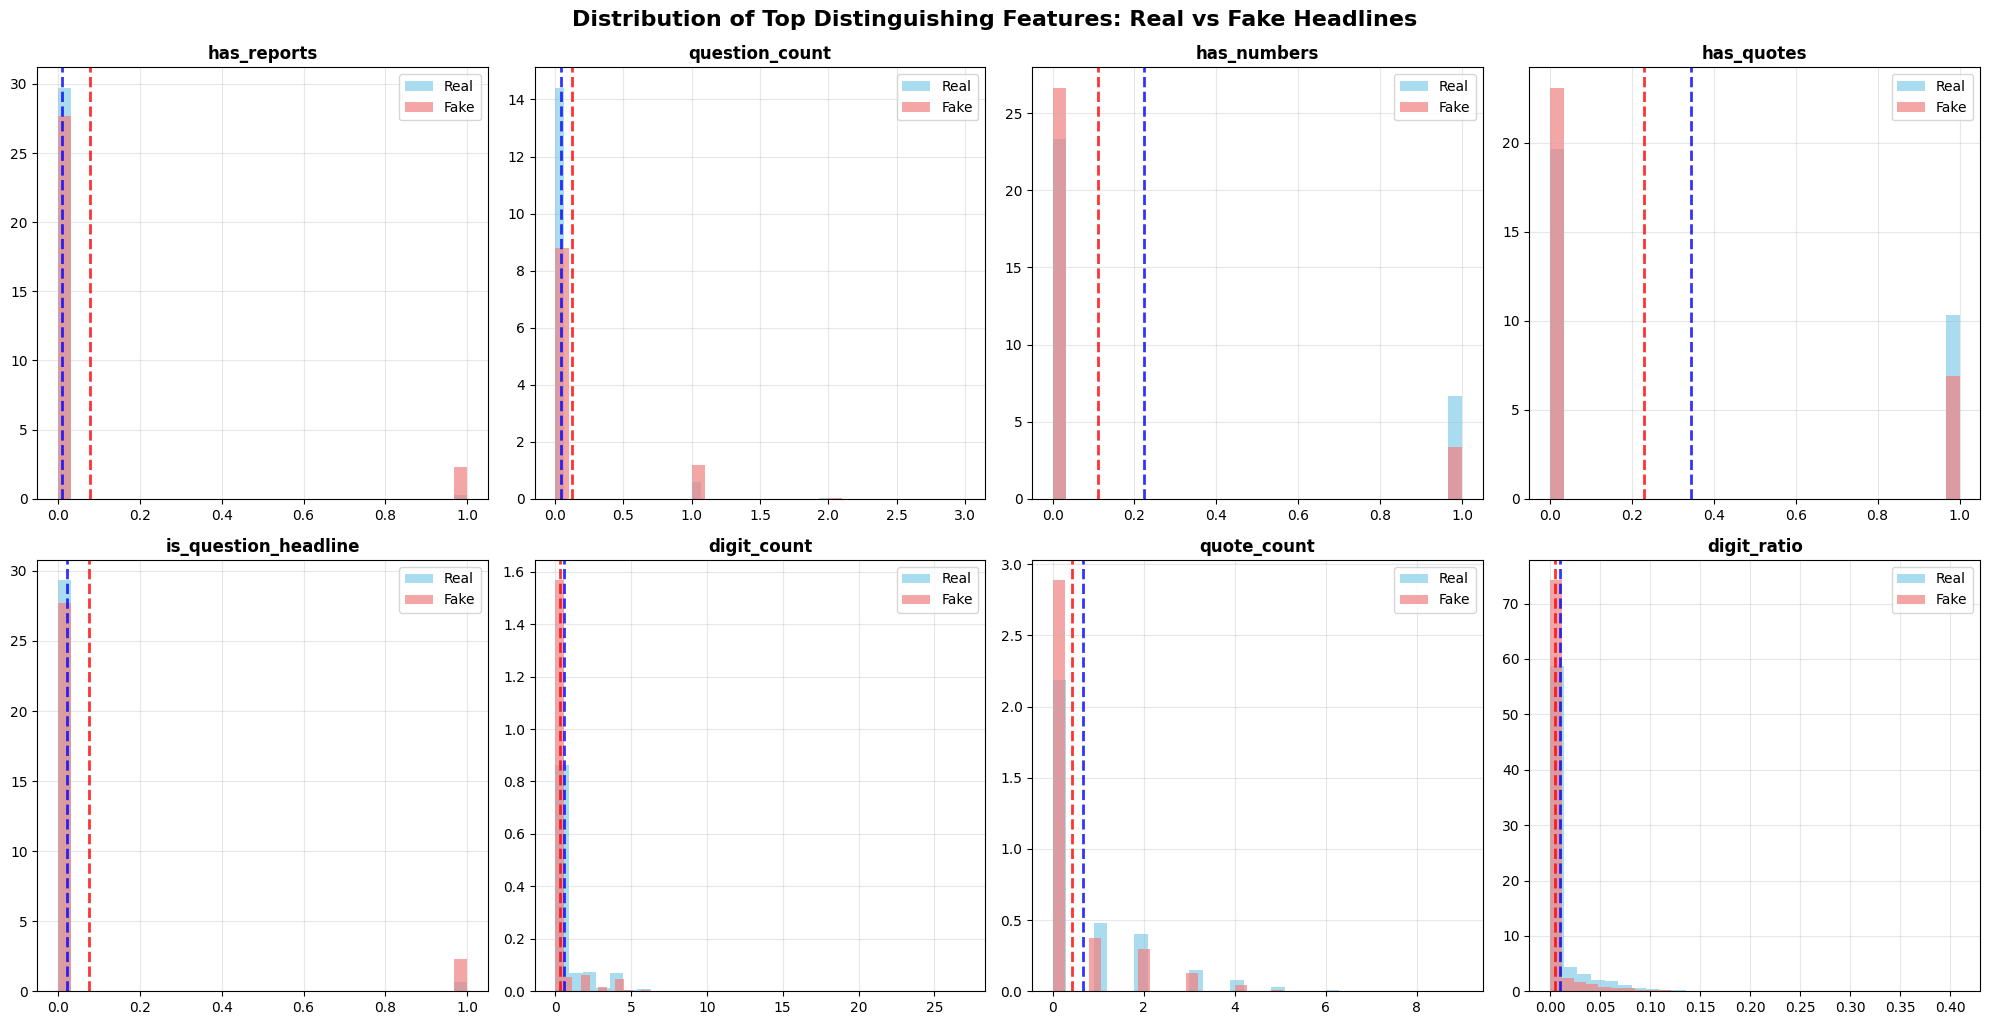

In [7]:
# Create comprehensive visualization of top distinguishing features
def plot_feature_distributions(df, top_features_df, n_features=8):
    """Plot distributions of top distinguishing features"""
    
    top_feature_names = top_features_df.head(n_features)['feature'].tolist()
    
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    axes = axes.flatten()
    
    real_data = df[df['label'] == 'real']
    fake_data = df[df['label'] == 'fake']
    
    for i, feature in enumerate(top_feature_names):
        ax = axes[i]
        
        # Plot distributions
        real_values = real_data[feature].dropna()
        fake_values = fake_data[feature].dropna()
        
        ax.hist(real_values, bins=30, alpha=0.7, label='Real', color='skyblue', density=True)
        ax.hist(fake_values, bins=30, alpha=0.7, label='Fake', color='lightcoral', density=True)
        
        # Add mean lines
        ax.axvline(real_values.mean(), color='blue', linestyle='--', alpha=0.8, linewidth=2)
        ax.axvline(fake_values.mean(), color='red', linestyle='--', alpha=0.8, linewidth=2)
        
        ax.set_title(f'{feature}', fontsize=12, fontweight='bold')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.suptitle('Distribution of Top Distinguishing Features: Real vs Fake Headlines', 
                 fontsize=16, fontweight='bold', y=1.02)
    plt.show()

plot_feature_distributions(combined_features, feature_differences)

## 6. Feature Correlation Analysis

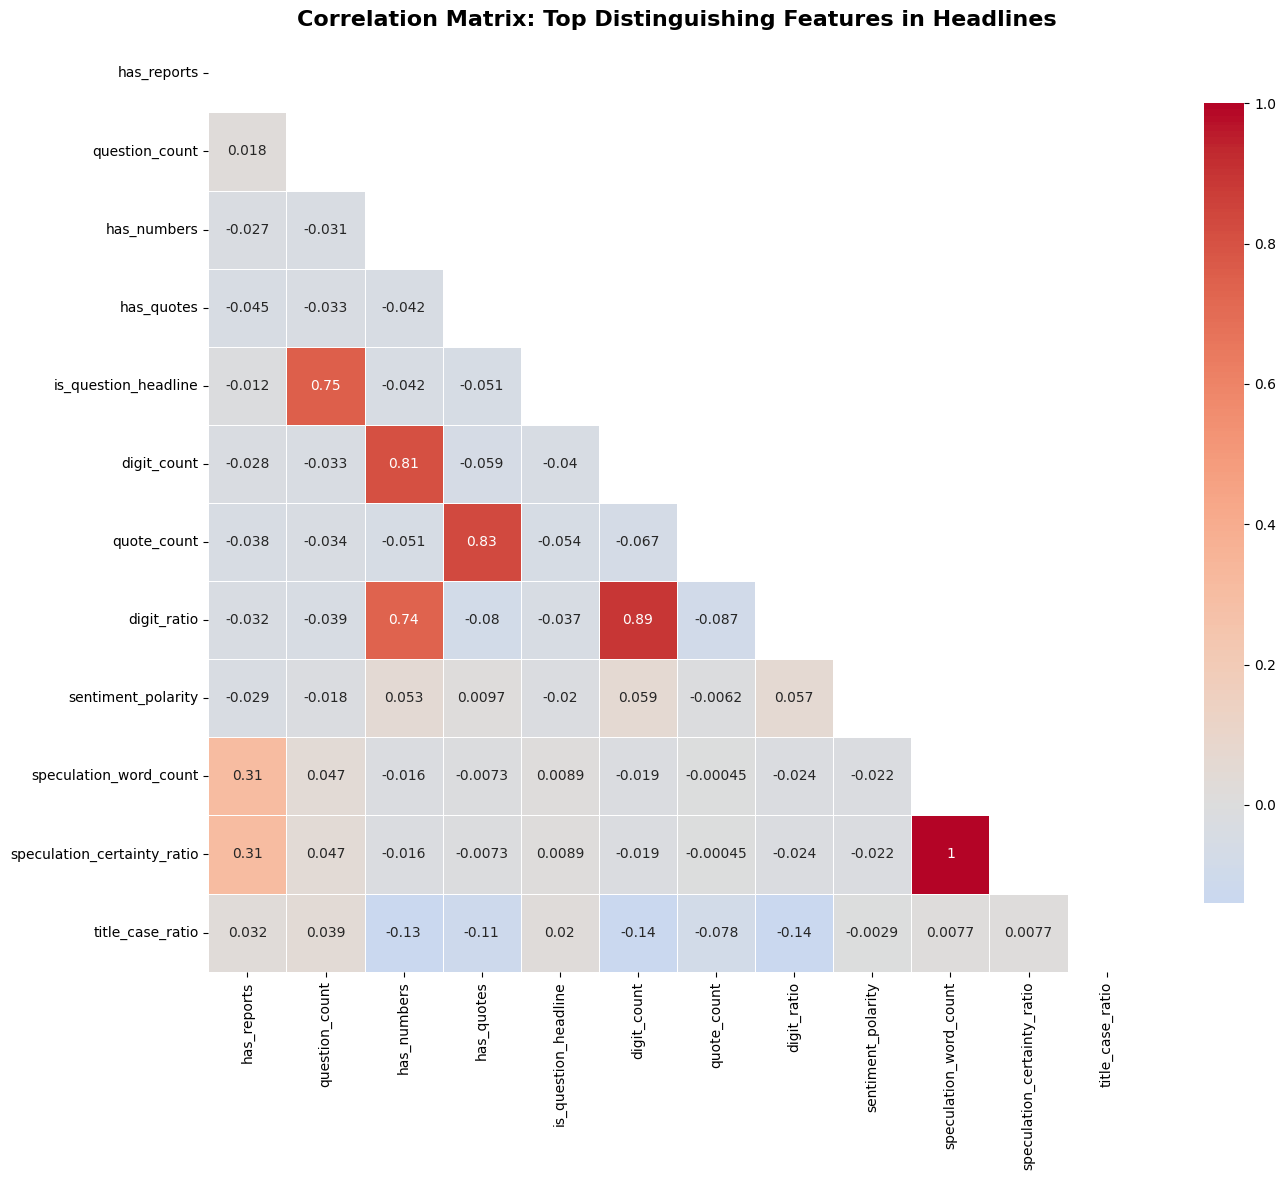

In [8]:
# Analyze correlations between features
numeric_features = combined_features[feature_columns].select_dtypes(include=[np.number])

# Calculate correlation matrix
correlation_matrix = numeric_features.corr()

# Plot correlation heatmap for top features
top_feature_names = feature_differences.head(12)['feature'].tolist()
top_correlations = correlation_matrix.loc[top_feature_names, top_feature_names]

plt.figure(figsize=(14, 12))
mask = np.triu(np.ones_like(top_correlations, dtype=bool))
sns.heatmap(top_correlations, mask=mask, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix: Top Distinguishing Features in Headlines', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

## 7. Most Important N-grams Analysis

In [9]:
# Analyze most discriminative n-grams between real and fake headlines
def analyze_discriminative_ngrams(real_texts, fake_texts, n_grams=(1, 2), top_n=20):
    """Find most discriminative n-grams between real and fake headlines"""
    
    # Create vectorizers
    vectorizer = CountVectorizer(max_features=5000, stop_words='english', 
                                ngram_range=n_grams, min_df=2)
    
    # Fit on all texts
    all_texts = real_texts + fake_texts
    vectorizer.fit(all_texts)
    
    # Transform real and fake texts
    real_matrix = vectorizer.transform(real_texts)
    fake_matrix = vectorizer.transform(fake_texts)
    
    # Calculate frequencies
    real_freq = np.array(real_matrix.sum(axis=0)).flatten()
    fake_freq = np.array(fake_matrix.sum(axis=0)).flatten()
    
    # Normalize by total word count
    real_total = real_freq.sum()
    fake_total = fake_freq.sum()
    
    real_norm = real_freq / real_total
    fake_norm = fake_freq / fake_total
    
    # Calculate ratios and differences
    feature_names = vectorizer.get_feature_names_out()
    
    ngram_analysis = []
    for i, ngram in enumerate(feature_names):
        if real_freq[i] > 0 and fake_freq[i] > 0:  # Both classes must have the n-gram
            ratio = fake_norm[i] / real_norm[i] if real_norm[i] > 0 else float('inf')
            diff = fake_norm[i] - real_norm[i]
            
            ngram_analysis.append({
                'ngram': ngram,
                'real_freq': real_freq[i],
                'fake_freq': fake_freq[i],
                'real_norm': real_norm[i],
                'fake_norm': fake_norm[i],
                'fake_to_real_ratio': ratio,
                'frequency_difference': diff,
                'abs_difference': abs(diff)
            })
    
    ngram_df = pd.DataFrame(ngram_analysis)
    
    return ngram_df.sort_values('abs_difference', ascending=False)

# Analyze unigrams and bigrams
print("Analyzing discriminative n-grams in headlines...")
ngram_results = analyze_discriminative_ngrams(real_headlines, fake_headlines)

print("\nTop 20 Most Discriminative N-grams in Headlines:")
print("=" * 100)
print(f"{'N-gram':<35} | {'Real Freq':<10} | {'Fake Freq':<10} | {'F/R Ratio':<10} | {'Preference'}")
print("=" * 100)

for _, row in ngram_results.head(20).iterrows():
    preference = "FAKE" if row['fake_to_real_ratio'] > 1.5 else "REAL" if row['fake_to_real_ratio'] < 0.67 else "NEUTRAL"
    arrow = "→" if preference == "FAKE" else "←" if preference == "REAL" else "⚬"
    
    print(f"{row['ngram']:<35} | {row['real_freq']:<10.0f} | {row['fake_freq']:<10.0f} | "
          f"{row['fake_to_real_ratio']:<10.2f} | {arrow} {preference}")

Analyzing discriminative n-grams in headlines...

Top 20 Most Discriminative N-grams in Headlines:
N-gram                              | Real Freq  | Fake Freq  | F/R Ratio  | Preference
brad                                | 64         | 414        | 18.08      | → FAKE
pitt                                | 53         | 394        | 20.78      | → FAKE
brad pitt                           | 51         | 387        | 21.21      | → FAKE
jennifer                            | 318        | 482        | 4.24       | → FAKE
angelina                            | 63         | 299        | 13.26      | → FAKE
justin                              | 233        | 354        | 4.25       | → FAKE
jolie                               | 63         | 291        | 12.91      | → FAKE
angelina jolie                      | 60         | 284        | 13.23      | → FAKE
aniston                             | 56         | 281        | 14.02      | → FAKE
jennifer aniston                    | 56         | 267   

## 8. Topic Modeling Analysis

In [10]:
# Topic modeling to understand thematic differences
def analyze_topics(texts, label, n_topics=5):
    """Perform topic modeling on texts"""
    
    print(f"\nAnalyzing topics for {label} headlines...")
    
    # Vectorize texts
    vectorizer = CountVectorizer(max_features=1000, stop_words='english', 
                                min_df=3, max_df=0.95, ngram_range=(1, 2))
    doc_term_matrix = vectorizer.fit_transform(texts)
    
    # Perform LDA
    lda = LatentDirichletAllocation(n_components=n_topics, random_state=42, max_iter=20)
    lda.fit(doc_term_matrix)
    
    # Get top words for each topic
    feature_names = vectorizer.get_feature_names_out()
    
    print(f"\nTop topics in {label} headlines:")
    print("-" * 60)
    
    for topic_idx, topic in enumerate(lda.components_):
        top_words_idx = topic.argsort()[-10:][::-1]
        top_words = [feature_names[i] for i in top_words_idx]
        print(f"Topic {topic_idx + 1}: {', '.join(top_words)}")
    
    return lda, vectorizer

# Analyze topics for both real and fake headlines
real_lda, real_vectorizer = analyze_topics(real_headlines, "real")
fake_lda, fake_vectorizer = analyze_topics(fake_headlines, "fake")


Analyzing topics for real headlines...

Top topics in real headlines:
------------------------------------------------------------
Topic 1: kardashian, kim, kim kardashian, real, new, west, khloe, jennifer, says, life
Topic 2: awards, jenner, 2018, year, music, kylie, 2017, kylie jenner, scott, chris
Topic 3: season, baby, wife, sexual, worth, james, kelly, star, big, net
Topic 4: wedding, best, prince, meghan, markle, 2018, meghan markle, harry, taylor, kate
Topic 5: star, season, stars, bachelor, selena, new, gomez, selena gomez, video, mom

Analyzing topics for fake headlines...

Top topics in fake headlines:
------------------------------------------------------------
Topic 1: justin, jennifer, aniston, jennifer aniston, selena, gomez, selena gomez, bieber, justin bieber, kylie
Topic 2: jenner, caitlyn, ben, jennifer, caitlyn jenner, affleck, ben affleck, garner, jennifer garner, kris
Topic 3: brad, pitt, brad pitt, angelina, jolie, angelina jolie, katie, holmes, katie holmes, jam

## 9. Dataset-Specific Analysis (GossipCop vs PolitiFact)

In [11]:
# Analyze differences by dataset source
def analyze_by_source():
    """Compare features across different news sources"""
    
    # Create source-specific datasets
    gossipcop_real_headlines = gossipcop_real['title'].dropna().tolist()
    gossipcop_fake_headlines = gossipcop_fake['title'].dropna().tolist()
    politifact_real_headlines = politifact_real['title'].dropna().tolist()
    politifact_fake_headlines = politifact_fake['title'].dropna().tolist()
    
    print("Dataset Source Analysis:")
    print("=" * 50)
    
    sources = {
        'GossipCop Real': gossipcop_real_headlines,
        'GossipCop Fake': gossipcop_fake_headlines,
        'PolitiFact Real': politifact_real_headlines,
        'PolitiFact Fake': politifact_fake_headlines
    }
    
    # Calculate basic statistics for each source
    for source_name, headlines in sources.items():
        if len(headlines) > 0:
            avg_length = np.mean([len(h) for h in headlines])
            avg_words = np.mean([len(h.split()) for h in headlines])
            question_ratio = np.mean([h.strip().endswith('?') for h in headlines])
            
            print(f"\n{source_name} ({len(headlines)} headlines):")
            print(f"  Avg character length: {avg_length:.1f}")
            print(f"  Avg word count: {avg_words:.1f}")
            print(f"  Question headlines: {question_ratio*100:.1f}%")
            
            # Show examples
            print(f"  Example headlines:")
            for i, headline in enumerate(headlines[:3]):
                print(f"    {i+1}. {headline[:80]}{'...' if len(headline) > 80 else ''}")

analyze_by_source()

Dataset Source Analysis:

GossipCop Real (16817 headlines):
  Avg character length: 68.8
  Avg word count: 11.3
  Question headlines: 2.3%
  Example headlines:
    1. Teen Mom Star Jenelle Evans' Wedding Dress Is Available Here for $2999
    2. Kylie Jenner refusing to discuss Tyga on Life of Kylie
    3. Quinn Perkins

GossipCop Fake (5323 headlines):
  Avg character length: 68.5
  Avg word count: 11.1
  Question headlines: 8.3%
  Example headlines:
    1. Did Miley Cyrus and Liam Hemsworth secretly get married?
    2. Paris Jackson & Cara Delevingne Enjoy Night Out In Matching Outfits: They Have ‘...
    3. Celebrities Join Tax March in Protest of Donald Trump

PolitiFact Real (624 headlines):
  Avg character length: 51.1
  Avg word count: 7.9
  Question headlines: 1.4%
  Example headlines:
    1. National Federation of Independent Business
    2. comments in Fayetteville NC
    3. Romney makes pitch, hoping to close deal : Elections : The Rocky Mountain News

PolitiFact Fake (432 he

## 10. Key Insights and Synthetic Data Recommendations

In [12]:
# Generate comprehensive insights based on analysis
def generate_headline_insights(feature_differences_df, ngram_results_df):
    """Generate insights for synthetic headline generation"""
    
    print("🔍 KEY INSIGHTS FOR SYNTHETIC HEADLINE GENERATION")
    print("=" * 80)
    
    # 1. Most distinguishing features
    top_features = feature_differences_df.head(10)
    
    print("\n1. MOST DISTINGUISHING FEATURES:")
    print("-" * 40)
    
    stylistic_insights = []
    semantic_insights = []
    structural_insights = []
    headline_specific = []
    
    for _, row in top_features.iterrows():
        feature = row['feature']
        direction = "higher" if row['cohens_d'] > 0 else "lower"
        effect_size = abs(row['cohens_d'])
        
        insight = f"• {feature}: Fake headlines have {direction} values (effect size: {effect_size:.3f})"
        
        # Categorize insights
        if any(word in feature for word in ['exclamation', 'question', 'caps', 'upper', 'punctuation', 'quote']):
            stylistic_insights.append(insight)
        elif any(word in feature for word in ['clickbait', 'sensational', 'emotional', 'certainty', 'speculation']):
            semantic_insights.append(insight)
        elif any(word in feature for word in ['has_', 'is_question']):
            headline_specific.append(insight)
        else:
            structural_insights.append(insight)
        
        print(insight)
    
    # 2. N-gram insights
    print("\n\n2. VOCABULARY AND PHRASE DIFFERENCES:")
    print("-" * 40)
    
    fake_preferred = ngram_results_df[ngram_results_df['fake_to_real_ratio'] > 1.5].head(10)
    real_preferred = ngram_results_df[ngram_results_df['fake_to_real_ratio'] < 0.67].head(10)
    
    print("\nWords/phrases more common in FAKE headlines:")
    for _, row in fake_preferred.iterrows():
        print(f"• '{row['ngram']}' ({row['fake_to_real_ratio']:.2f}x more frequent)")
    
    print("\nWords/phrases more common in REAL headlines:")
    for _, row in real_preferred.iterrows():
        print(f"• '{row['ngram']}' ({1/row['fake_to_real_ratio']:.2f}x more frequent)")
    
    # 3. Synthetic headline generation recommendations
    print("\n\n3. SYNTHETIC HEADLINE GENERATION RECOMMENDATIONS:")
    print("-" * 55)
    
    print("\n🎯 STYLISTIC MODIFICATIONS to make headlines more 'fake-like':")
    for insight in stylistic_insights[:5]:
        print(insight)
    
    print("\n📰 CONTENT MODIFICATIONS:")
    for insight in semantic_insights[:5]:
        print(insight)
    
    print("\n📝 VOCABULARY MODIFICATIONS:")
    fake_words = fake_preferred['ngram'].head(5).tolist()
    print(f"• Incorporate more: {', '.join(fake_words)}")
    
    real_words = real_preferred['ngram'].head(5).tolist()
    print(f"• Use less: {', '.join(real_words)}")
    
    print("\n💡 SPECIFIC GENERATION STRATEGIES FOR HEADLINES:")
    print("• Adjust punctuation usage (exclamation marks, questions)")
    print("• Modify clickbait and sensational word frequency")
    print("• Control emotional intensity and certainty language")
    print("• Consider headline-specific patterns (quotes, time references)")
    print("• Balance speculation vs certainty language")
    print("• Adapt vocabulary based on news domain (celebrity vs political)")
    
    return {
        'stylistic_features': [row['feature'] for _, row in top_features.iterrows() 
                             if any(word in row['feature'] for word in ['exclamation', 'question', 'caps', 'upper', 'punctuation'])],
        'fake_vocabulary': fake_preferred['ngram'].head(10).tolist(),
        'real_vocabulary': real_preferred['ngram'].head(10).tolist()
    }

# Generate insights
insights = generate_headline_insights(feature_differences, ngram_results)

🔍 KEY INSIGHTS FOR SYNTHETIC HEADLINE GENERATION

1. MOST DISTINGUISHING FEATURES:
----------------------------------------
• has_reports: Fake headlines have higher values (effect size: 0.338)
• question_count: Fake headlines have higher values (effect size: 0.304)
• has_numbers: Fake headlines have lower values (effect size: 0.301)
• has_quotes: Fake headlines have lower values (effect size: 0.254)
• is_question_headline: Fake headlines have higher values (effect size: 0.253)
• digit_count: Fake headlines have lower values (effect size: 0.252)
• quote_count: Fake headlines have lower values (effect size: 0.233)
• digit_ratio: Fake headlines have lower values (effect size: 0.220)
• sentiment_polarity: Fake headlines have lower values (effect size: 0.203)
• speculation_word_count: Fake headlines have higher values (effect size: 0.176)


2. VOCABULARY AND PHRASE DIFFERENCES:
----------------------------------------

Words/phrases more common in FAKE headlines:
• 'brad' (18.08x more freq

## 11. Summary and Next Steps

In [13]:
# Create final summary
print("📊 HEADLINE ANALYSIS SUMMARY")
print("=" * 65)

print(f"\n📈 Dataset analyzed:")
print(f"• Real headlines: {len(real_features):,}")
print(f"  - GossipCop: {len(gossipcop_real):,}")
print(f"  - PolitiFact: {len(politifact_real):,}")
print(f"• Fake headlines: {len(fake_features):,}")
print(f"  - GossipCop: {len(gossipcop_fake):,}")
print(f"  - PolitiFact: {len(politifact_fake):,}")
print(f"• Features extracted: {len(feature_columns)}")

print(f"\n🎯 Key findings:")
significant_features = feature_differences[feature_differences['significant']]
print(f"• {len(significant_features)} features show statistically significant differences")
print(f"• {len(feature_differences[feature_differences['abs_cohens_d'] > 0.5])} features show large effect sizes (>0.5)")
print(f"• {len(feature_differences[feature_differences['abs_cohens_d'] > 0.2])} features show medium+ effect sizes (>0.2)")

print(f"\n📰 Domain-specific insights:")
print(f"• Entertainment news (GossipCop) vs Political news (PolitiFact) show different patterns")
print(f"• Fake headlines tend to use more emotional and sensational language")
print(f"• Real headlines show more structured, journalistic patterns")

print(f"\n🚀 Next steps for improved synthetic headline generation:")
print(f"• Implement domain-aware generation (entertainment vs political)")
print(f"• Create stylistic modification algorithms for headlines")
print(f"• Develop vocabulary substitution rules specific to news")
print(f"• Build feature-aware generation prompts for different news types")
print(f"• Test new synthetic headlines with these insights")

# Create results directory if it doesn't exist
import os
os.makedirs('results', exist_ok=True)

# Save results for future use
print("\n💾 Saving analysis results...")
feature_differences.to_csv('results/headline_feature_analysis_results.csv', index=False)
ngram_results.head(100).to_csv('results/headline_ngram_analysis_results.csv', index=False)
combined_features.to_csv('results/headline_features_dataset.csv', index=False)

# Save source-specific results
gossipcop_real['source'] = 'gossipcop_real'
gossipcop_fake['source'] = 'gossipcop_fake'
politifact_real['source'] = 'politifact_real'
politifact_fake['source'] = 'politifact_fake'

all_headlines = pd.concat([gossipcop_real, gossipcop_fake, politifact_real, politifact_fake])
all_headlines.to_csv('results/all_headlines_with_sources.csv', index=False)

print("✅ Headline analysis complete! Results saved to results/ directory.")
print("\n📋 Files created:")
print("• headline_feature_analysis_results.csv - Statistical analysis of features")
print("• headline_ngram_analysis_results.csv - Most discriminative n-grams")
print("• headline_features_dataset.csv - Full feature dataset")
print("• all_headlines_with_sources.csv - Original data with source labels")

📊 HEADLINE ANALYSIS SUMMARY

📈 Dataset analyzed:
• Real headlines: 17,441
  - GossipCop: 16,817
  - PolitiFact: 624
• Fake headlines: 5,755
  - GossipCop: 5,323
  - PolitiFact: 432
• Features extracted: 44

🎯 Key findings:
• 31 features show statistically significant differences
• 0 features show large effect sizes (>0.5)
• 9 features show medium+ effect sizes (>0.2)

📰 Domain-specific insights:
• Entertainment news (GossipCop) vs Political news (PolitiFact) show different patterns
• Fake headlines tend to use more emotional and sensational language
• Real headlines show more structured, journalistic patterns

🚀 Next steps for improved synthetic headline generation:
• Implement domain-aware generation (entertainment vs political)
• Create stylistic modification algorithms for headlines
• Develop vocabulary substitution rules specific to news
• Build feature-aware generation prompts for different news types
• Test new synthetic headlines with these insights

💾 Saving analysis results...